In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import h5py
import pandas as pd
import scipy

from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1086: Num

In [2]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [3]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

In [17]:
amplicons

,CHROM,end_pos,id,r1_counts,r2_counts,start_pos
0,b'1',115256723,b'AML_v2_NRAS_115256512',43222,43124,115256488
1,b'1',115258825,b'AML_v2_NRAS_115258635',36200,36072,115258610
2,b'2',25457372,b'AML_v2_DNMT3A_25457166',25986,25973,25457144
3,b'2',25458763,b'AML_v2_DNMT3A_25458540',48517,48463,25458519
4,b'2',25460046,b'AML_v2_DNMT3A_25459813',13589,13567,25459794
...,...,...,...,...,...,...
122,b'21',36206913,b'AML_v2_RUNX1_36206703',41584,41519,36206684
123,b'21',36231937,b'AML_v2_RUNX1_36231714',22554,22536,36231693
124,b'21',36253046,b'AML_v2_RUNX1_36252844',51341,51276,36252820
125,b'21',44514808,b'AML_v2_U2AF1_44514570',65367,65269,44514550


In [5]:
cell_filters.filtered.value_counts()

filtered
0    1201
1      39
Name: count, dtype: int64

# Sanity check

<Axes: ylabel='Count'>

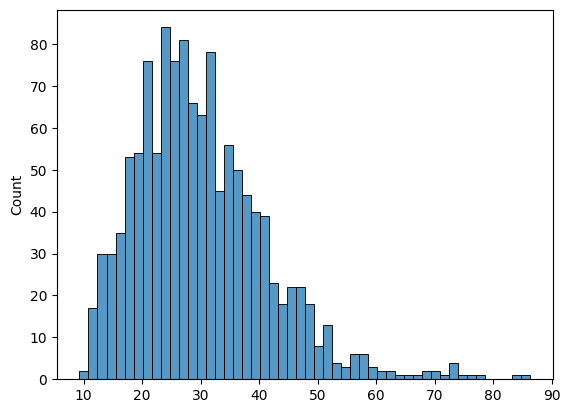

In [6]:
# mean read count per cell
cell_mean_read_count = read_counts.to_numpy().mean(axis=1)
sns.histplot(cell_mean_read_count, bins=50)

<Axes: ylabel='Count'>

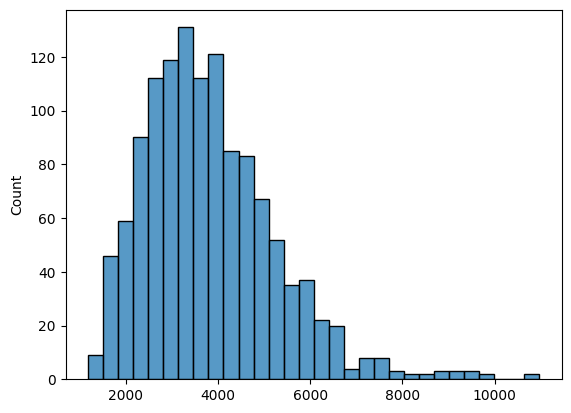

In [21]:
# total number of read per cell
sns.histplot(read_counts.sum(axis=1),bins=30)

<Axes: ylabel='Count'>

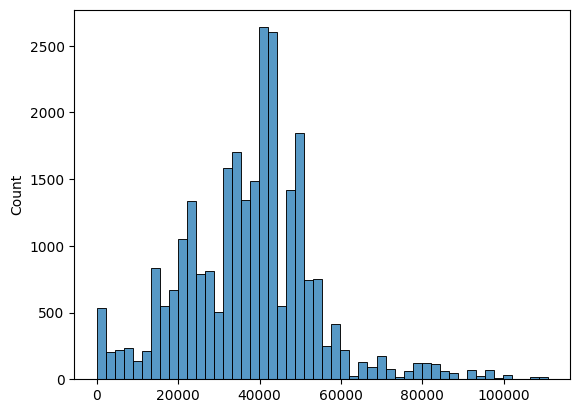

In [248]:
# coverage per variant 
sns.histplot(covs.sum(axis=0),bins=50)

In [ ]:
sns.pointplot(data = read_counts.to_numpy(), errorbar='sd')

<Axes: ylabel='Count'>

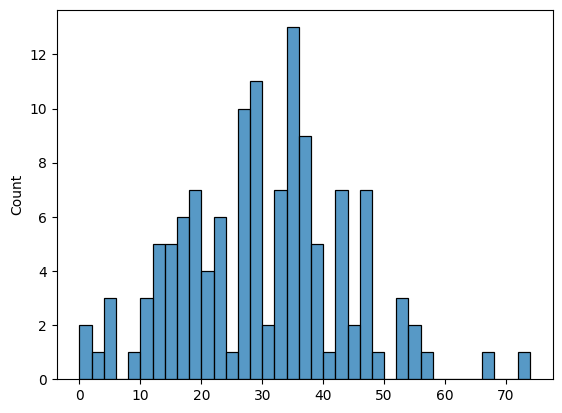

In [7]:
amplicon_mean_read_count = read_counts.to_numpy().mean(axis=0)
sns.histplot(amplicon_mean_read_count, bins=20, binwidth=2)

<Axes: ylabel='Count'>

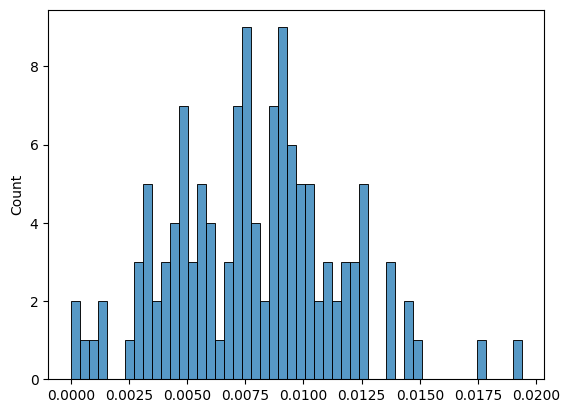

In [12]:
# amplicon mean prob (after normalization), different begavior 
sns.histplot(read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).to_numpy().mean(axis=0), bins=50)

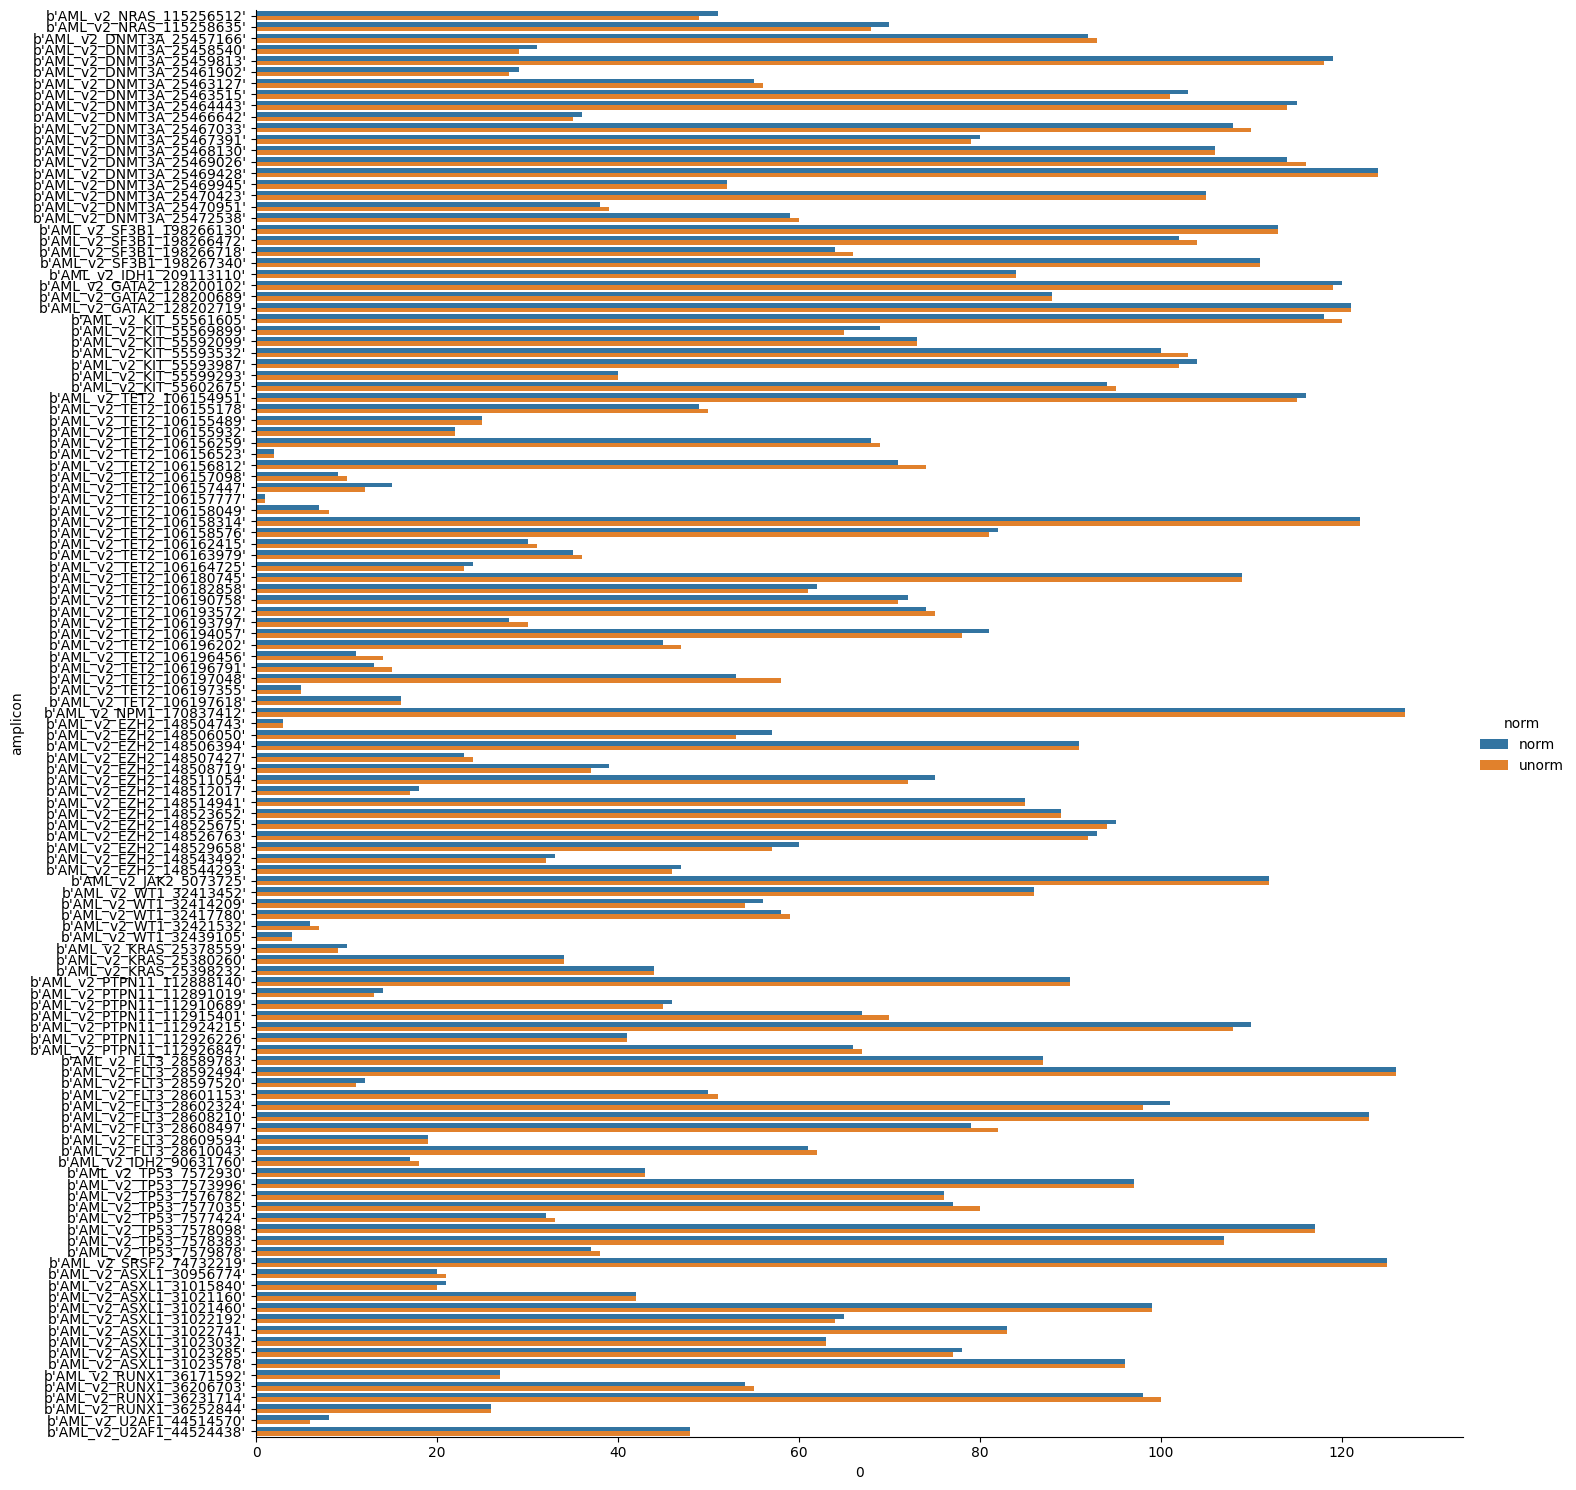

In [159]:
with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0).rank(ascending=False).values
,'unorm_rank': read_counts.mean(axis=0).rank(ascending=False).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(127)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index
sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=15
)

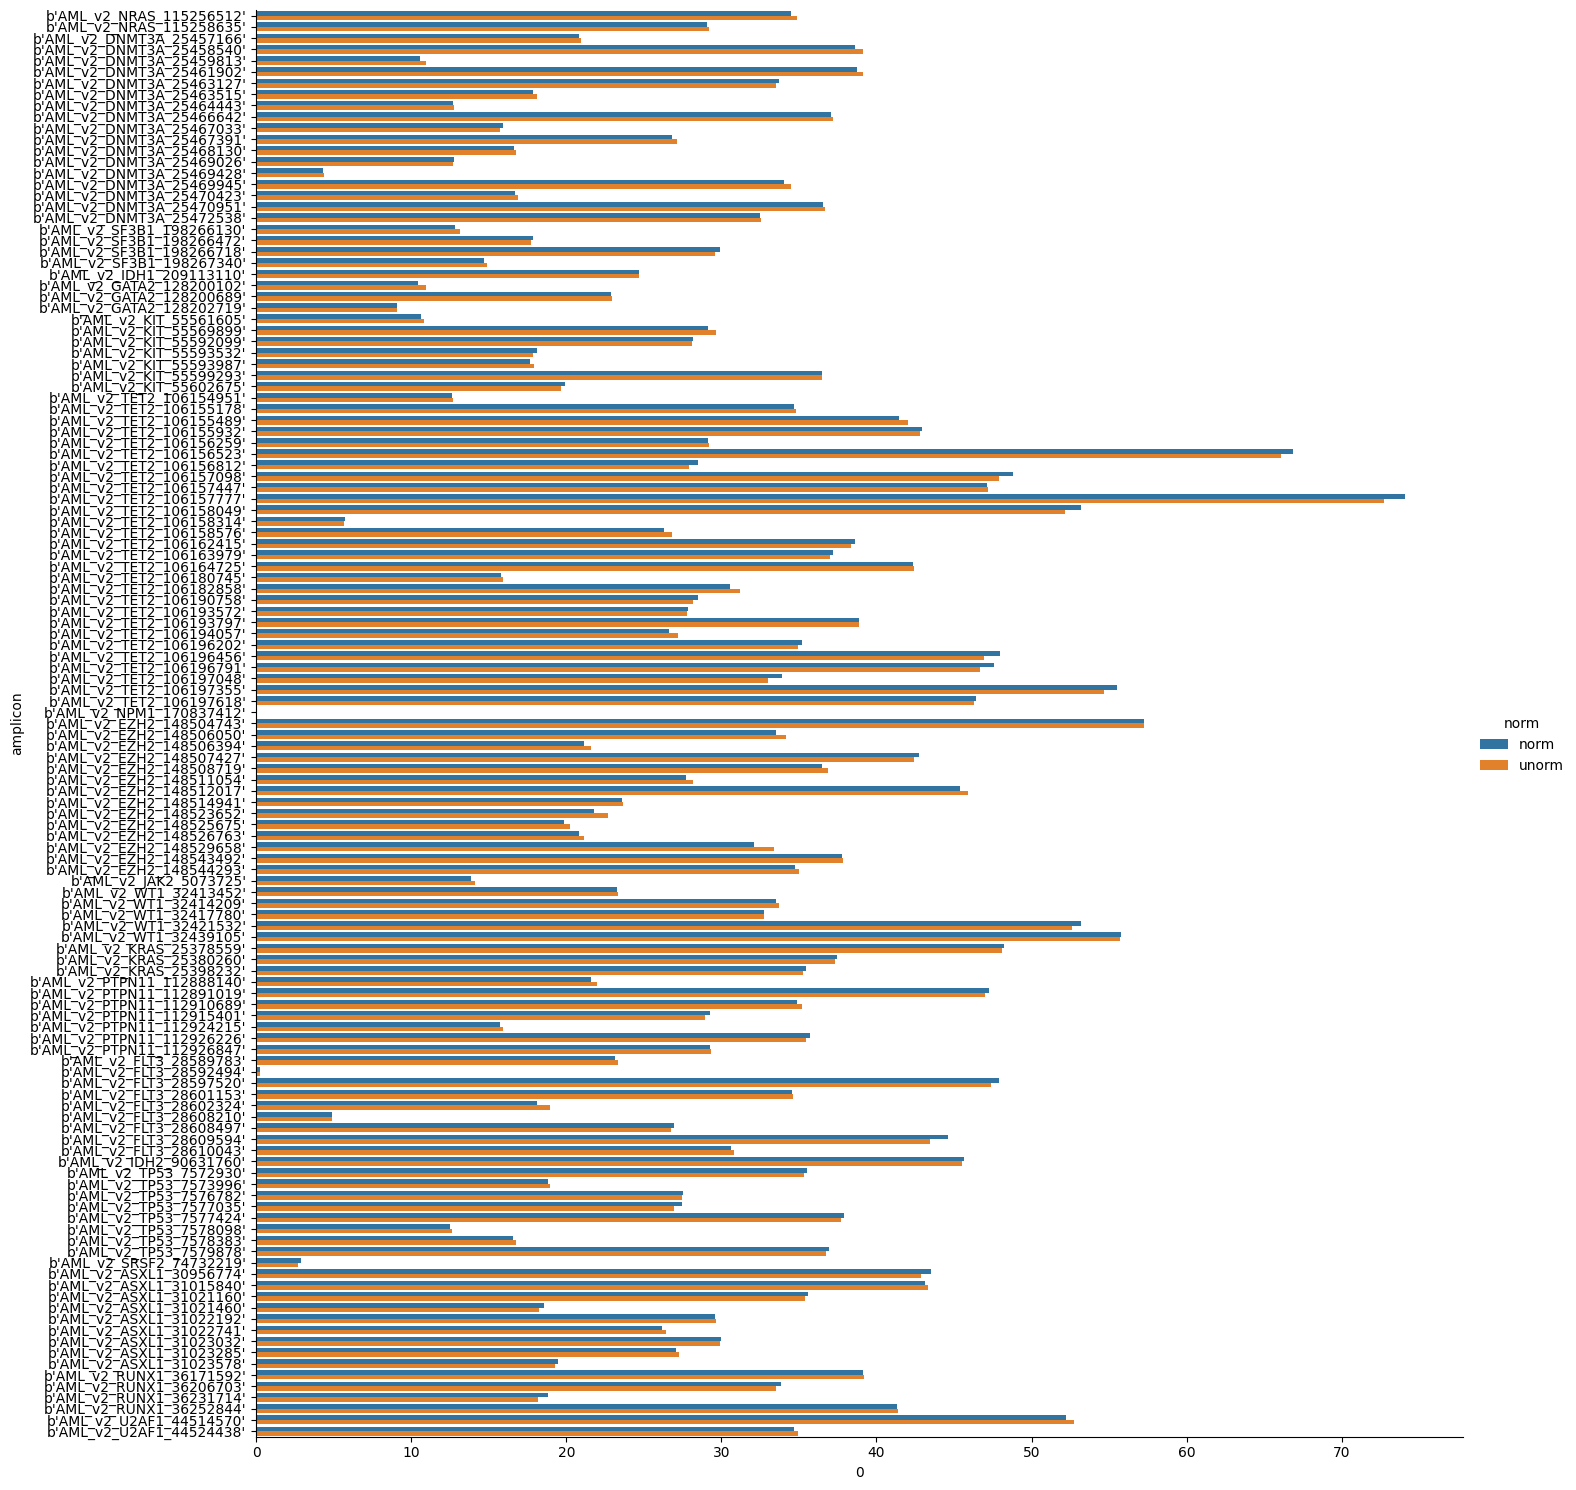

In [64]:
mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0)*mean_tot_nb_read_cell).values
,'unorm_rank': read_counts.mean(axis=0).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(127)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index

sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=15
)

In [ ]:
sns.pointplot(data = read_counts.to_numpy().T, errorbar='sd')

<Axes: ylabel='Count'>

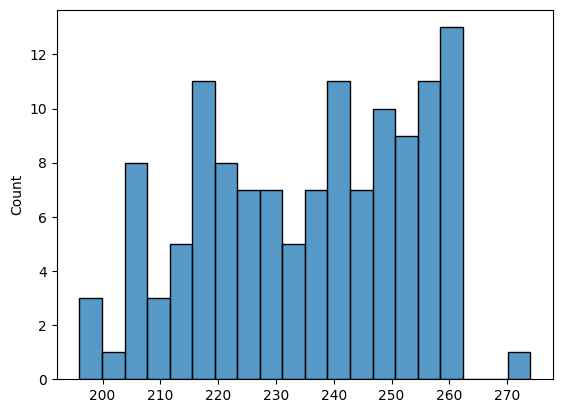

In [15]:
# variance of size of amplicon

sns.histplot(amplicons.end_pos - amplicons.start_pos, bins=20)

<Axes: xlabel='length', ylabel='CHROM'>

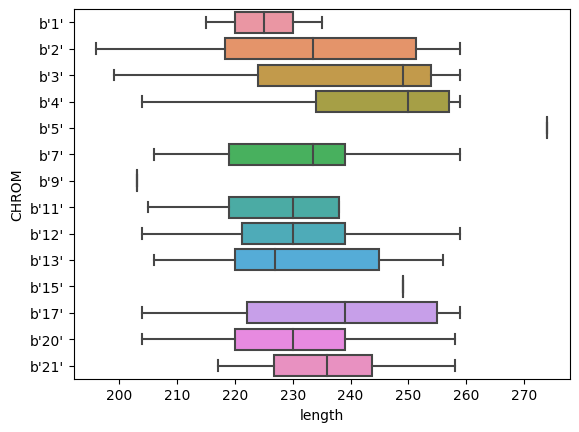

In [66]:
# amplicon size variance in chromosome
sanity_amplicon = amplicons.copy()
sanity_amplicon['length'] = sanity_amplicon.end_pos - sanity_amplicon.start_pos
sanity_amplicon[['CHROM','length']].groupby(['CHROM']).mean()
sns.boxplot(data=sanity_amplicon, x='length',y='CHROM')

In [35]:
# number of amplicon per chomosome
sanity_amplicon.groupby(['CHROM']).count()

,end_pos,id,r1_counts,r2_counts,start_pos,length
CHROM,,,,,,
b'1',2,2,2,2,2,2
b'11',5,5,5,5,5,5
b'12',10,10,10,10,10,10
b'13',9,9,9,9,9,9
b'15',1,1,1,1,1,1
b'17',9,9,9,9,9,9
b'2',22,22,22,22,22,22
b'20',9,9,9,9,9,9
b'21',6,6,6,6,6,6


<Axes: xlabel='length', ylabel='r1_counts'>

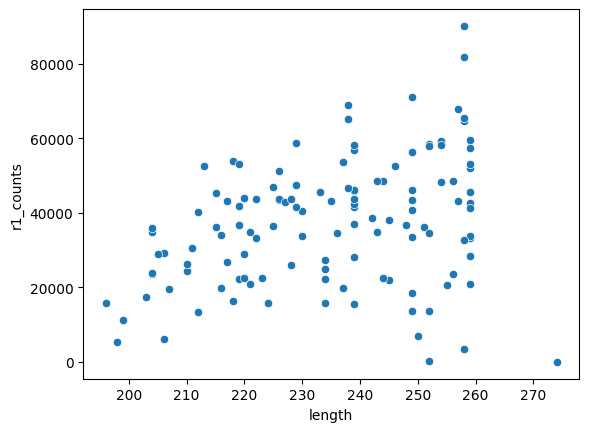

In [73]:
# link between size of amplicon and total read count
sns.scatterplot(data=sanity_amplicon,x='length',y='r1_counts')

In [228]:
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # max read variant of amplicon
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

,sum,r1_counts,r2_counts
amplicon,,,
b'AML_v2_ASXL1_30956774',96748,53141,53111
b'AML_v2_ASXL1_31015840',94131,53753,53732
b'AML_v2_ASXL1_31021160',82671,43869,43155
b'AML_v2_ASXL1_31021460',45419,22622,23268
b'AML_v2_ASXL1_31022192',70378,36757,36710
...,...,...,...
b'AML_v2_WT1_32413452',57089,28945,28925
b'AML_v2_WT1_32414209',79400,41840,41799
b'AML_v2_WT1_32417780',77764,40601,40580


In [239]:
# after filtering variants
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv.iloc[variants[variants.filtered == 1].index]
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants[variants.filtered == 1].amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # max read variant of amplicon
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

,sum,r1_counts,r2_counts
amplicon,,,
b'AML_v2_ASXL1_30956774',96748,53141,53111
b'AML_v2_ASXL1_31015840',94131,53753,53732
b'AML_v2_ASXL1_31021160',82671,43869,43155
b'AML_v2_ASXL1_31021460',45419,22622,23268
b'AML_v2_ASXL1_31022192',70378,36757,36710
...,...,...,...
b'AML_v2_WT1_32413452',57089,28945,28925
b'AML_v2_WT1_32414209',79400,41840,41799
b'AML_v2_WT1_32417780',77764,40601,40580


In [187]:
# total read count snv of amplicon
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts
sanity_snv['per_snv'] = sanity_snv['sum']/sanity_snv['count'] # mean 
sanity_snv['median_var'] = median_var

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

,sum,count,per_snv,median_var,r1_counts,r2_counts
amplicon,,,,,,
b'AML_v2_ASXL1_30956774',11193265,196,57108.494898,48934.0,53141,53111
b'AML_v2_ASXL1_31015840',10736037,210,51123.985714,47677.5,53753,53732
b'AML_v2_ASXL1_31021160',10078496,215,46876.725581,41229.0,43869,43155
b'AML_v2_ASXL1_31021460',5008863,185,27074.935135,23058.0,22622,23268
b'AML_v2_ASXL1_31022192',8233281,228,36110.881579,35451.5,36757,36710
...,...,...,...,...,...,...
b'AML_v2_WT1_32413452',6440547,174,37014.637931,28626.5,28945,28925
b'AML_v2_WT1_32414209',9164606,196,46758.193878,39851.0,41840,41799
b'AML_v2_WT1_32417780',8834845,204,43308.063725,39056.0,40601,40580


In [254]:
# total read count snv of amplicon, different pos snv 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
sanity_snv = sanity_snv.drop_duplicates('POS')
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts
sanity_snv['per_snv'] = sanity_snv['sum']/sanity_snv['count'] # mean 
sanity_snv['median_var'] = median_var

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

,sum,count,per_snv,median_var,r1_counts,r2_counts
amplicon,,,,,,
b'AML_v2_ASXL1_30956774',10027490,173,57962.369942,48938.0,53141,53111
b'AML_v2_ASXL1_31015840',9690454,189,51272.243386,47676.0,53753,53732
b'AML_v2_ASXL1_31021160',8669995,185,46864.837838,41227.0,43869,43155
b'AML_v2_ASXL1_31021460',4711682,174,27078.632184,23058.0,22622,23268
b'AML_v2_ASXL1_31022192',7383531,204,36193.779412,35450.5,36757,36710
...,...,...,...,...,...,...
b'AML_v2_WT1_32413452',5812236,156,37257.923077,28627.5,28945,28925
b'AML_v2_WT1_32414209',8129307,172,47263.412791,39854.5,41840,41799
b'AML_v2_WT1_32417780',8092142,185,43741.308108,39056.0,40601,40580


<Axes: xlabel='count', ylabel='Count'>

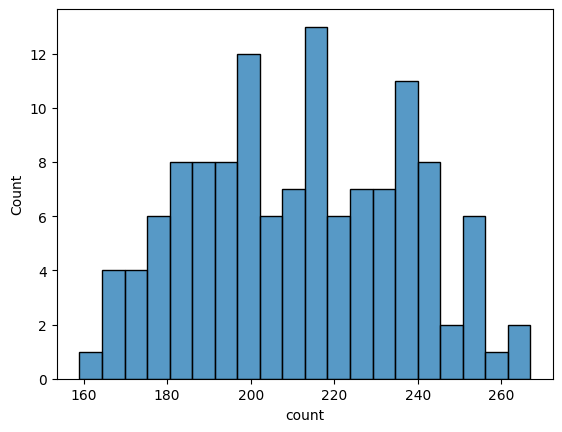

In [138]:
# nb of variant per amplicon
sns.histplot(sanity_snv['count'], bins=20)

<Axes: xlabel='length', ylabel='count'>

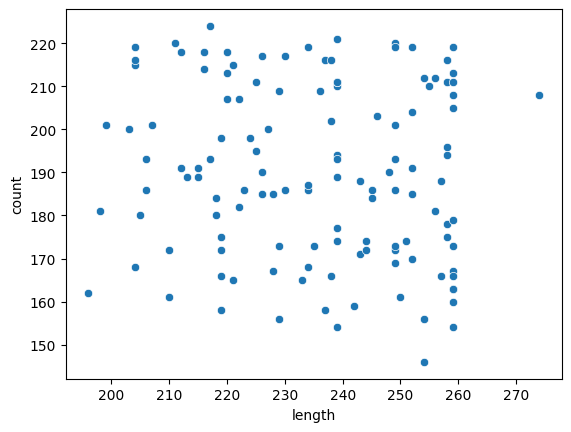

In [256]:
# link between size of amplicon and nb variant
sanity_snv['length'] = (amplicons.end_pos - amplicons.start_pos).values
sns.scatterplot(data=sanity_snv,x='length',y='count')

In [131]:
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
snv_amplicon_read = sanity_snv[['sum','amplicon']]
snv_amplicon_read

,sum,amplicon
b'chr1:115256513:G/A',40179,b'AML_v2_NRAS_115256512'
b'chr1:115256513:G/T',40179,b'AML_v2_NRAS_115256512'
b'chr1:115256514:G/A',40412,b'AML_v2_NRAS_115256512'
b'chr1:115256515:C/',40424,b'AML_v2_NRAS_115256512'
b'chr1:115256516:A/G',40426,b'AML_v2_NRAS_115256512'
...,...,...
b'chr21:44524605:T/C',40950,b'AML_v2_U2AF1_44524438'
b'chr21:44524606:T/C',40954,b'AML_v2_U2AF1_44524438'
b'chr21:44524607:A/',40958,b'AML_v2_U2AF1_44524438'
b'chr21:44524608:A/G',40959,b'AML_v2_U2AF1_44524438'


In [177]:
ranking_amplicon = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0).rank(ascending=False).values
,'unorm_rank': read_counts.mean(axis=0).rank(ascending=False).values})
top10 = ranking_amplicon.sort_values(by='norm_rank').iloc[:10].amplicon.values
top20 = ranking_amplicon.sort_values(by='norm_rank').iloc[:20].amplicon.values

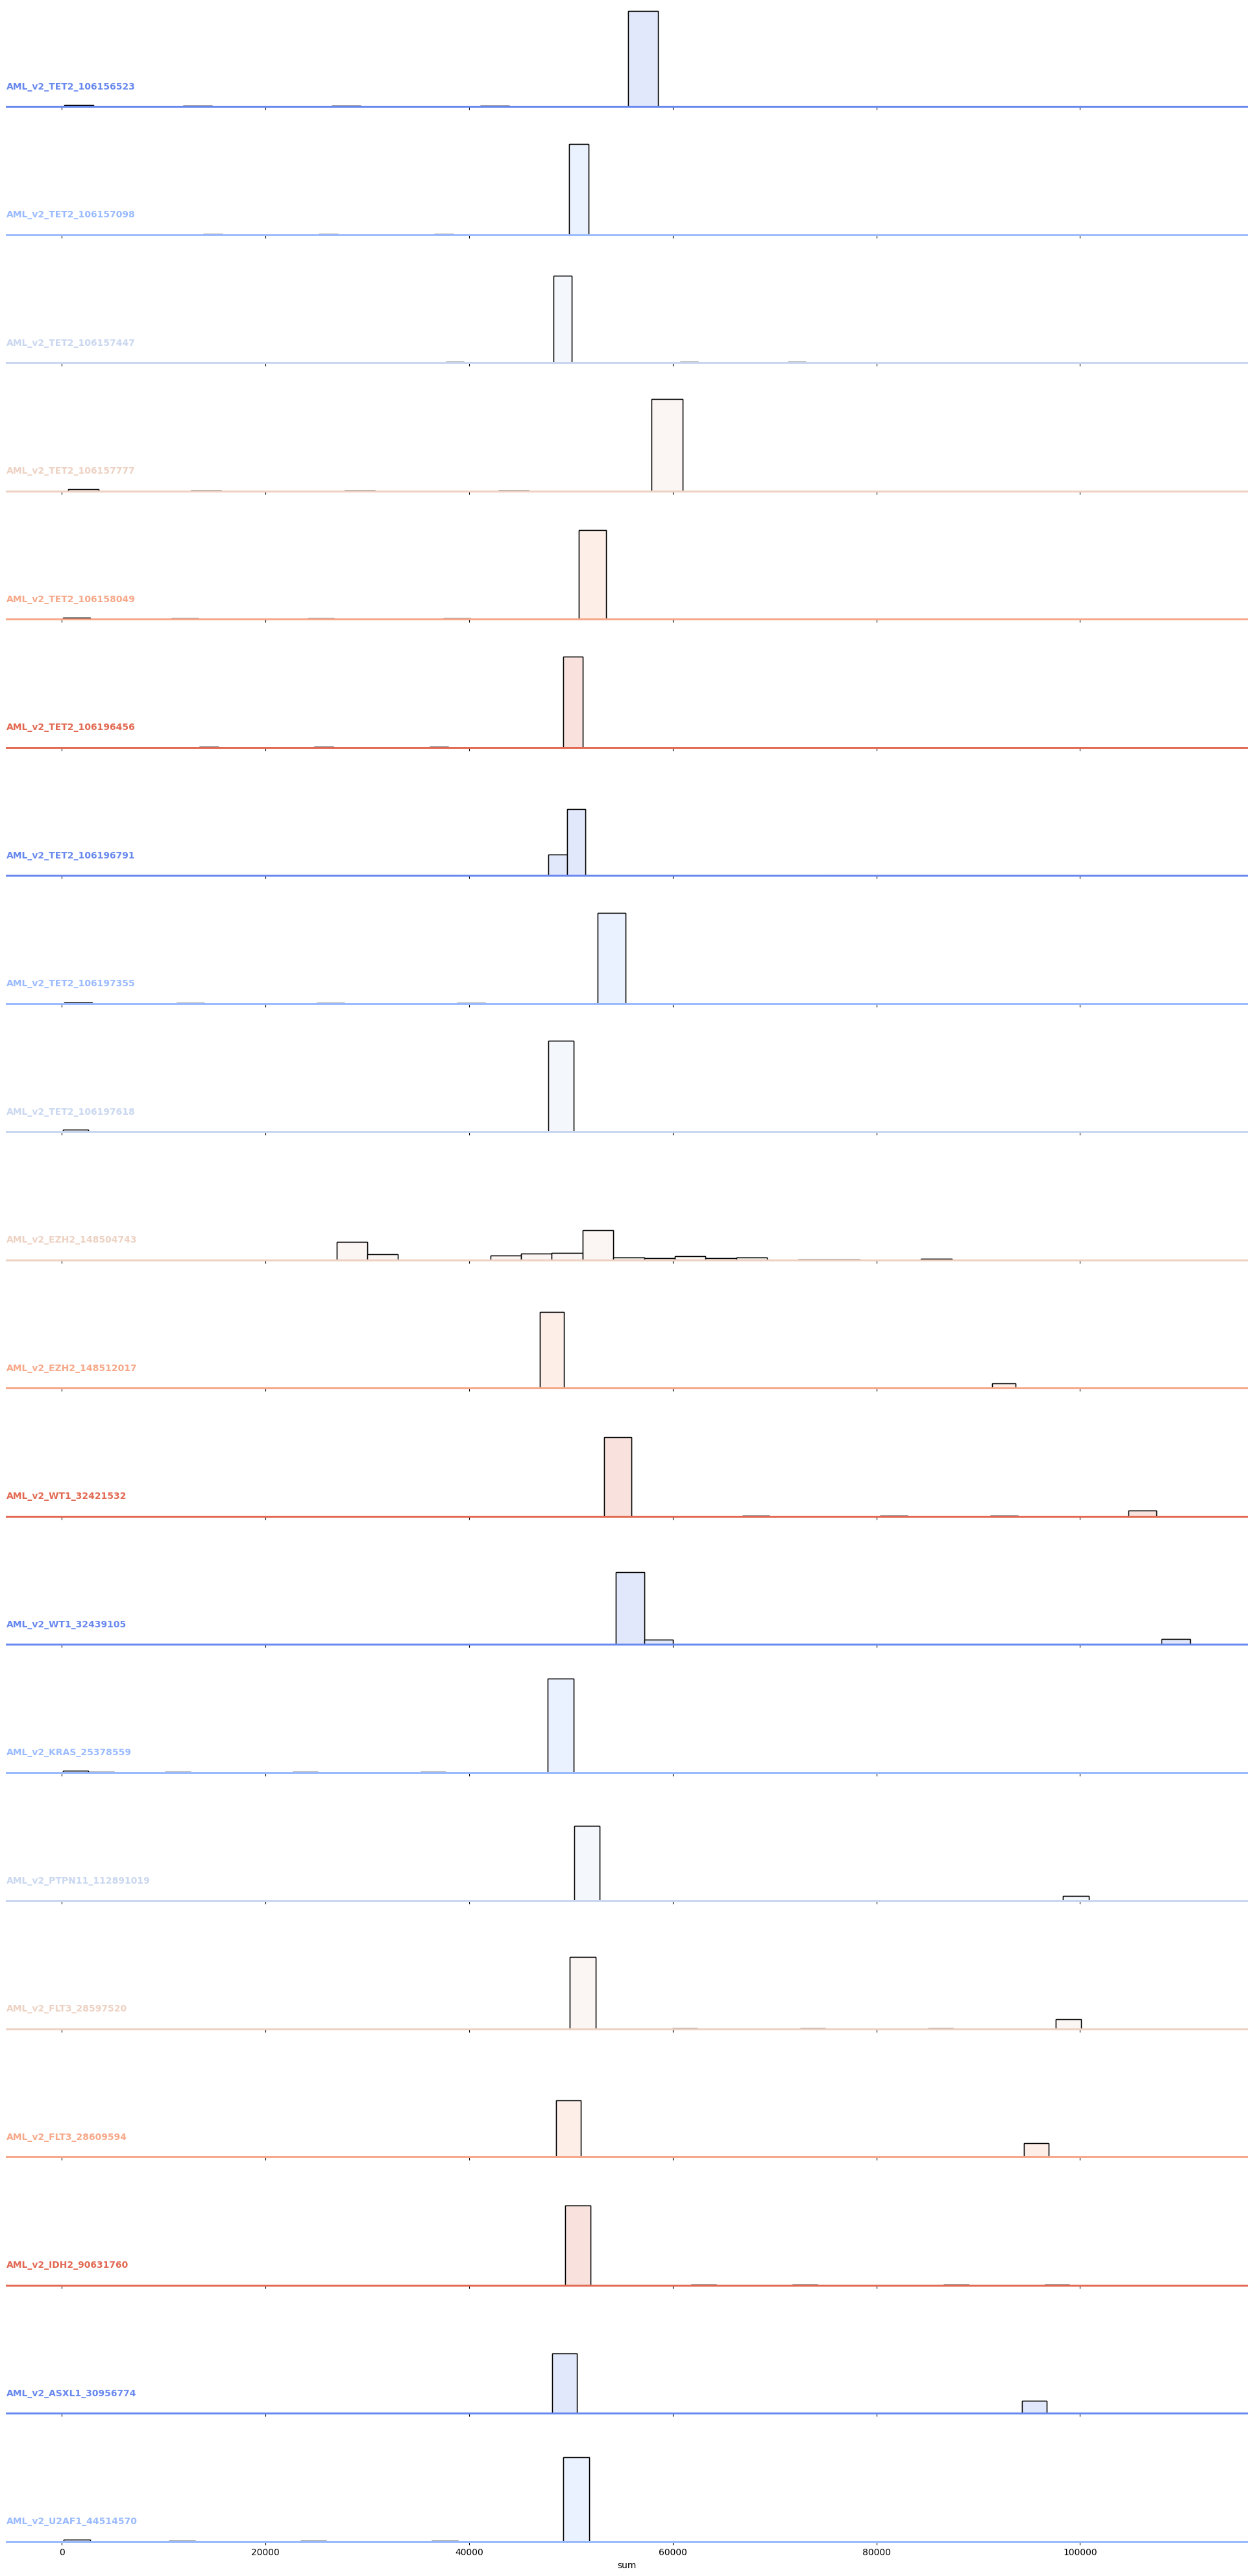

In [178]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm')

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(snv_amplicon_read[snv_amplicon_read.amplicon.isin(top20)], row='amplicon' , hue='amplicon', aspect=10, height=2, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.histplot, 'sum',
      fill=True, bins=20)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.histplot, 'sum', 
      bins=20, 
      color="w")
"""g.map(sns.kdeplot, 0,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 0, 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)"""

# here we add a horizontal line for each plot
g.map(plt.axhline, y='sum',
      lw=2, clip_on=False)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'sum')

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.15)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [193]:
# nb of different pos variant (26910 in total)
variants.POS.value_counts()

POS
148508833    3
7578523      3
106154998    3
148504854    3
106154992    3
            ..
106158196    1
106158195    1
106158194    1
106158193    1
44524609     1
Name: count, Length: 24110, dtype: int64

In [191]:
variants.filtered.value_counts()

filtered
1    26866
0       44
Name: count, dtype: int64

# HEATMAP

## SNV VAF

<Axes: >

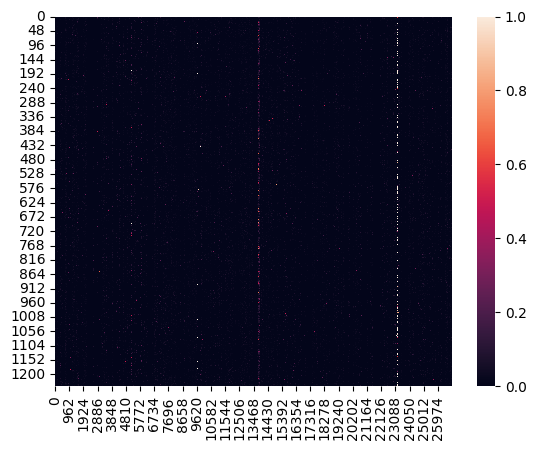

In [10]:
snv_vaf = vafs.to_numpy()
sns.heatmap(snv_vaf)

In [260]:
amplicons

,CHROM,end_pos,id,r1_counts,r2_counts,start_pos
0,b'1',115256723,b'AML_v2_NRAS_115256512',43222,43124,115256488
1,b'1',115258825,b'AML_v2_NRAS_115258635',36200,36072,115258610
2,b'2',25457372,b'AML_v2_DNMT3A_25457166',25986,25973,25457144
3,b'2',25458763,b'AML_v2_DNMT3A_25458540',48517,48463,25458519
4,b'2',25460046,b'AML_v2_DNMT3A_25459813',13589,13567,25459794
...,...,...,...,...,...,...
122,b'21',36206913,b'AML_v2_RUNX1_36206703',41584,41519,36206684
123,b'21',36231937,b'AML_v2_RUNX1_36231714',22554,22536,36231693
124,b'21',36253046,b'AML_v2_RUNX1_36252844',51341,51276,36252820
125,b'21',44514808,b'AML_v2_U2AF1_44514570',65367,65269,44514550


In [264]:
read_counts

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_ASXL1_31022741',b'AML_v2_ASXL1_31023032',b'AML_v2_ASXL1_31023285',b'AML_v2_ASXL1_31023578',b'AML_v2_RUNX1_36171592',b'AML_v2_RUNX1_36206703',b'AML_v2_RUNX1_36231714',b'AML_v2_RUNX1_36252844',b'AML_v2_U2AF1_44514570',b'AML_v2_U2AF1_44524438'
b'AACAACCTACAGAAGTGA-1',37,30,23,40,20,58,40,16,24,34,...,37,38,33,20,51,34,33,45,53,30
b'AACAACCTATCTATGACA-1',11,19,25,22,5,26,16,15,27,45,...,25,25,24,25,27,35,33,34,47,26
b'AACAACTGGCAACGCACA-1',44,26,10,23,25,52,29,6,17,32,...,19,36,29,10,48,20,9,36,35,26
b'AACACACTCTTACAGTGT-1',59,31,22,44,7,32,24,12,16,43,...,19,18,36,23,75,47,19,46,63,46
b'AACAGCAGTCGTCTGCTG-1',31,32,42,74,9,77,55,24,21,58,...,28,35,35,21,36,40,36,62,61,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',9,4,19,19,9,27,29,14,12,24,...,23,16,11,13,25,16,4,13,21,16
b'TTGGAGAACTGAACTTGC-1',109,1,50,102,19,66,54,38,14,79,...,71,58,45,42,65,51,30,129,133,92
b'TTGGTAACTTCTGCGCTG-1',46,47,20,58,31,60,40,20,20,57,...,30,24,38,23,76,50,28,56,68,45
b'TTGTCAACCGCAGCAGTG-1',69,42,20,52,11,70,47,19,21,58,...,28,30,40,14,79,48,23,44,50,48


In [261]:
vafs

,b'chr1:115256513:G/A',b'chr1:115256513:G/T',b'chr1:115256514:G/A',b'chr1:115256515:C/',b'chr1:115256516:A/G',b'chr1:115256516:A/T',b'chr1:115256517:C/',b'chr1:115256518:T/C',b'chr1:115256518:T/G',b'chr1:115256519:G/',...,b'chr21:44524600:T/C',b'chr21:44524601:A/',b'chr21:44524602:C/',b'chr21:44524603:T/',b'chr21:44524604:T/',b'chr21:44524605:T/C',b'chr21:44524606:T/C',b'chr21:44524607:A/',b'chr21:44524608:A/G',b'chr21:44524609:C/'
b'AACAACCTACAGAAGTGA-1',0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.142857,0.0
b'AACAACCTATCTATGACA-1',0.222222,0.000000,0.000000,0.0,0.090909,0.090909,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0
b'AACAACTGGCAACGCACA-1',0.023256,0.023256,0.000000,0.0,0.023256,0.023256,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0
b'AACACACTCTTACAGTGT-1',0.019608,0.019608,0.000000,0.0,0.000000,0.000000,0.0,0.019608,0.019608,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0
b'AACAGCAGTCGTCTGCTG-1',0.000000,0.000000,0.000000,0.0,0.032258,0.032258,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.025000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.111111,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0625,0.0,0.000000,0.0
b'TTGGAGAACTGAACTTGC-1',0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.019608,0.019608,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018868,0.0000,0.0,0.037736,0.0
b'TTGGTAACTTCTGCGCTG-1',0.021739,0.021739,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0
b'TTGTCAACCGCAGCAGTG-1',0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.020833,0.0


In [259]:
covs.T

,b'AACAACCTACAGAAGTGA-1',b'AACAACCTATCTATGACA-1',b'AACAACTGGCAACGCACA-1',b'AACACACTCTTACAGTGT-1',b'AACAGCAGTCGTCTGCTG-1',b'AACAGCAGTGATGCTCCT-1',b'AACCGCTGAAACAACCTA-1',b'AACCGCTGAACCACGCTA-1',b'AACGCATTGCGTTAATGG-1',b'AACGCCTACACCATACTT-1',...,b'TTGCAGTCATGCTATGAA-1',b'TTGCCAGATATGGACGTT-1',b'TTGCCAGATTCCTTCGTA-1',b'TTGCCGTAGAGATGAGAT-1',b'TTGCCGTAGGAGGTGAGC-1',b'TTGGACTTCCGCTTATGA-1',b'TTGGAGAACTGAACTTGC-1',b'TTGGTAACTTCTGCGCTG-1',b'TTGTCAACCGCAGCAGTG-1',b'TTGTTAGAGAATCTCCTA-1'
b'chr1:115256513:G/A',36,9,43,51,31,54,21,36,34,51,...,39,22,45,33,40,9,51,46,50,49
b'chr1:115256513:G/T',36,9,43,51,31,54,21,36,34,51,...,39,22,45,33,40,9,51,46,50,49
b'chr1:115256514:G/A',36,11,43,51,31,54,21,36,34,51,...,39,22,45,33,40,9,51,46,50,49
b'chr1:115256515:C/',36,11,43,51,31,54,21,36,34,51,...,39,22,45,33,40,9,51,46,50,51
b'chr1:115256516:A/G',36,11,43,51,31,54,21,36,34,51,...,39,22,45,33,40,9,51,46,50,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'chr21:44524605:T/C',30,26,26,46,40,49,19,33,42,53,...,12,37,49,25,29,16,53,45,48,50
b'chr21:44524606:T/C',30,26,26,46,40,49,19,33,42,53,...,12,37,49,25,29,16,53,45,48,50
b'chr21:44524607:A/',30,26,26,46,40,49,19,33,42,53,...,12,37,49,25,29,16,53,45,48,50
b'chr21:44524608:A/G',28,26,26,46,40,49,19,33,42,53,...,12,37,49,25,29,16,53,45,48,50


In [67]:
sns.clustermap(vafs.to_numpy())

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


: 

: 

## SNV 

In [56]:
variants.amplicon[variants.id == b'chr1:115256513:G/A'].values[0]

b'AML_v2_NRAS_115256512'

In [265]:
snv_read_count = vafs.copy()

for col in snv_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    snv_read_count[col] = read_counts[amplicon]

In [269]:
vaf_by_hand = covs/snv_read_count

In [277]:
np.unique(vaf_by_hand.round(decimals=1).values)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 3. , 3.5, 4. , 5. , 6. , inf, nan])

In [278]:
np.unique(vafs.round(decimals=1).values)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [287]:
vaf_by_hand.std().sort_values(ascending=False).iloc[:1000].values

array([0.54105627, 0.52187396, 0.51461873, 0.51352207, 0.50837912,
       0.50716379, 0.50676362, 0.50325117, 0.50307296, 0.50210892,
       0.50029496, 0.50000721, 0.49905392, 0.49894515, 0.49839595,
       0.49839595, 0.49796157, 0.49692204, 0.49627585, 0.49623657,
       0.49619596, 0.49563499, 0.49512926, 0.49409794, 0.49387533,
       0.49387011, 0.49376487, 0.49372863, 0.49331428, 0.49296542,
       0.49271892, 0.49268171, 0.49257975, 0.49254287, 0.49250485,
       0.49250485, 0.49244757, 0.49233622, 0.49221248, 0.49221248,
       0.49211228, 0.49203969, 0.49184546, 0.49171653, 0.49168658,
       0.49148567, 0.4914553 , 0.49125556, 0.49120605, 0.49097866,
       0.49082341, 0.49074878, 0.49062304, 0.49057788, 0.4903725 ,
       0.49036192, 0.49008616, 0.49008339, 0.48991941, 0.48965374,
       0.48950063, 0.48933561, 0.48913955, 0.48911946, 0.48896454,
       0.48867542, 0.48845979, 0.48845617, 0.48841465, 0.48840459,
       0.48817385, 0.48805057, 0.48797887, 0.48794332, 0.48785

In [290]:
from sklearn.feature_selection import VarianceThreshold

vaf_by_hand[vaf_by_hand==np.inf]=0
sel = VarianceThreshold(threshold=0.2)
sel.fit_transform(vaf_by_hand)
sel

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.2)

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


<Axes: >

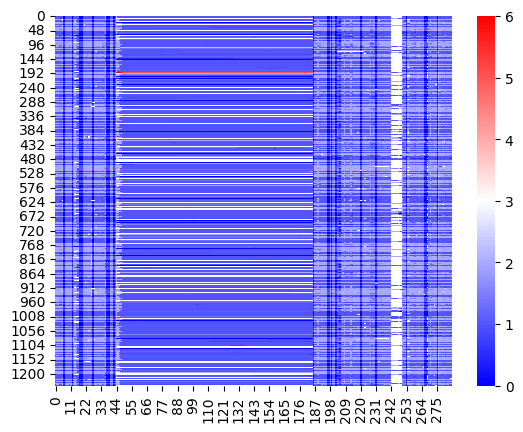

In [293]:
sns.heatmap(sel.fit_transform(vaf_by_hand), cmap="bwr")

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

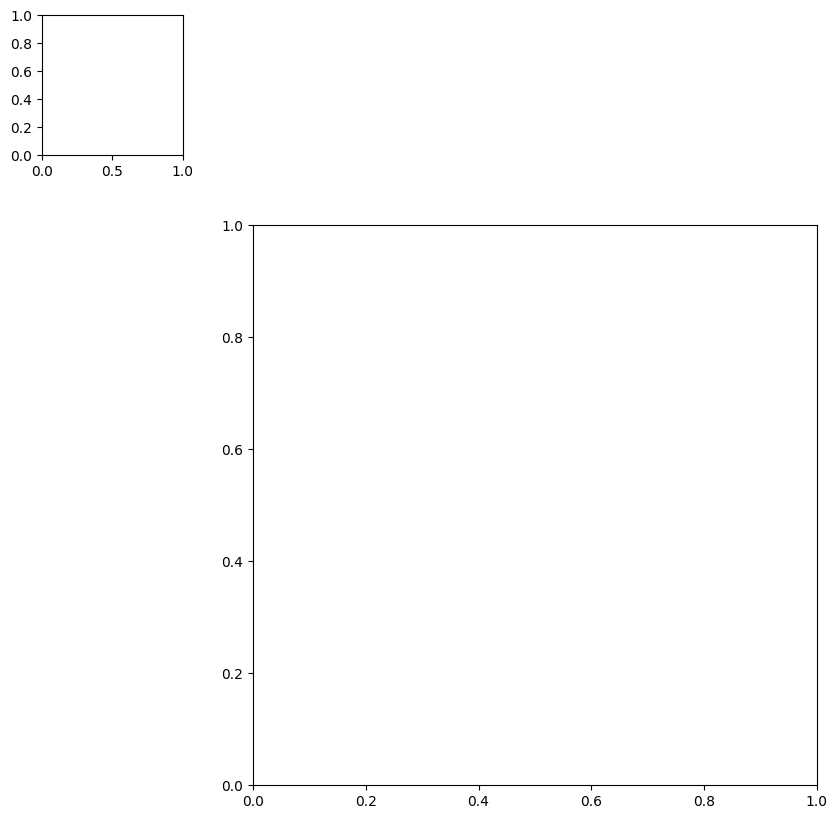

In [294]:
sns.clustermap(sel.fit_transform(vaf_by_hand), cmap="bwr")

## CNA amplicon

<Axes: >

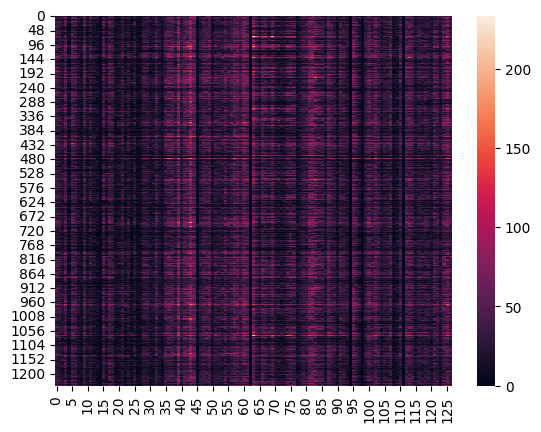

In [13]:
sns.heatmap(read_counts.to_numpy())

In [14]:
read_counts.sum(axis=1)

b'AACAACCTACAGAAGTGA-1'    4375
b'AACAACCTATCTATGACA-1'    2938
b'AACAACTGGCAACGCACA-1'    3361
b'AACACACTCTTACAGTGT-1'    4337
b'AACAGCAGTCGTCTGCTG-1'    5043
                           ... 
b'TTGGACTTCCGCTTATGA-1'    1923
b'TTGGAGAACTGAACTTGC-1'    8954
b'TTGGTAACTTCTGCGCTG-1'    4834
b'TTGTCAACCGCAGCAGTG-1'    4834
b'TTGTTAGAGAATCTCCTA-1'    5842
Length: 1240, dtype: int64

In [11]:
read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_ASXL1_31022741',b'AML_v2_ASXL1_31023032',b'AML_v2_ASXL1_31023285',b'AML_v2_ASXL1_31023578',b'AML_v2_RUNX1_36171592',b'AML_v2_RUNX1_36206703',b'AML_v2_RUNX1_36231714',b'AML_v2_RUNX1_36252844',b'AML_v2_U2AF1_44514570',b'AML_v2_U2AF1_44524438'
b'AACAACCTACAGAAGTGA-1',0.008457,0.006857,0.005257,0.009143,0.004571,0.013257,0.009143,0.003657,0.005486,0.007771,...,0.008457,0.008686,0.007543,0.004571,0.011657,0.007771,0.007543,0.010286,0.012114,0.006857
b'AACAACCTATCTATGACA-1',0.003744,0.006467,0.008509,0.007488,0.001702,0.008850,0.005446,0.005106,0.009190,0.015317,...,0.008509,0.008509,0.008169,0.008509,0.009190,0.011913,0.011232,0.011572,0.015997,0.008850
b'AACAACTGGCAACGCACA-1',0.013091,0.007736,0.002975,0.006843,0.007438,0.015472,0.008628,0.001785,0.005058,0.009521,...,0.005653,0.010711,0.008628,0.002975,0.014281,0.005951,0.002678,0.010711,0.010414,0.007736
b'AACACACTCTTACAGTGT-1',0.013604,0.007148,0.005073,0.010145,0.001614,0.007378,0.005534,0.002767,0.003689,0.009915,...,0.004381,0.004150,0.008301,0.005303,0.017293,0.010837,0.004381,0.010606,0.014526,0.010606
b'AACAGCAGTCGTCTGCTG-1',0.006147,0.006345,0.008328,0.014674,0.001785,0.015269,0.010906,0.004759,0.004164,0.011501,...,0.005552,0.006940,0.006940,0.004164,0.007139,0.007932,0.007139,0.012294,0.012096,0.007932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.004680,0.002080,0.009880,0.009880,0.004680,0.014041,0.015081,0.007280,0.006240,0.012480,...,0.011960,0.008320,0.005720,0.006760,0.013001,0.008320,0.002080,0.006760,0.010920,0.008320
b'TTGGAGAACTGAACTTGC-1',0.012173,0.000112,0.005584,0.011392,0.002122,0.007371,0.006031,0.004244,0.001564,0.008823,...,0.007929,0.006478,0.005026,0.004691,0.007259,0.005696,0.003350,0.014407,0.014854,0.010275
b'TTGGTAACTTCTGCGCTG-1',0.009516,0.009723,0.004137,0.011998,0.006413,0.012412,0.008275,0.004137,0.004137,0.011791,...,0.006206,0.004965,0.007861,0.004758,0.015722,0.010343,0.005792,0.011585,0.014067,0.009309
b'TTGTCAACCGCAGCAGTG-1',0.014274,0.008688,0.004137,0.010757,0.002276,0.014481,0.009723,0.003930,0.004344,0.011998,...,0.005792,0.006206,0.008275,0.002896,0.016343,0.009930,0.004758,0.009102,0.010343,0.009930


c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


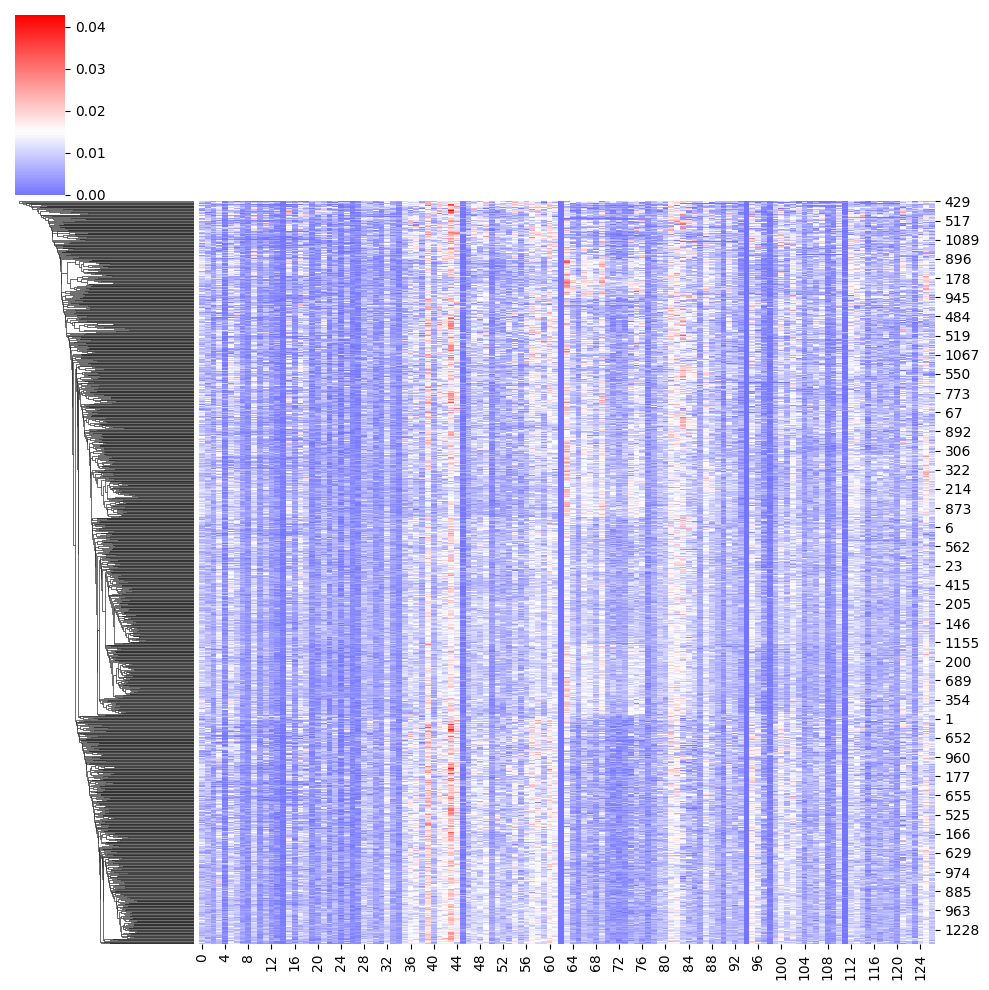

In [13]:
sns.clustermap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), col_cluster=False, cmap="bwr", center = 0.015)

<Axes: >

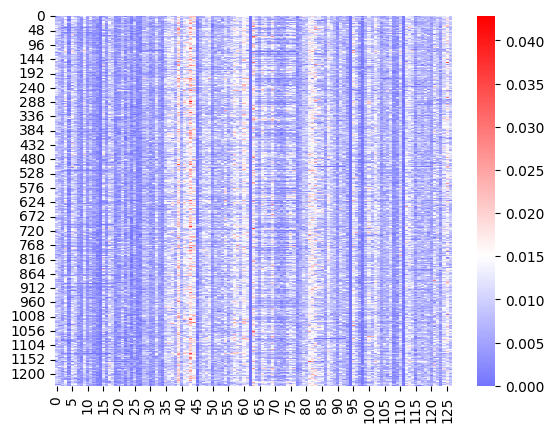

In [27]:
sns.heatmap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), cmap = "bwr", center = 0.015)


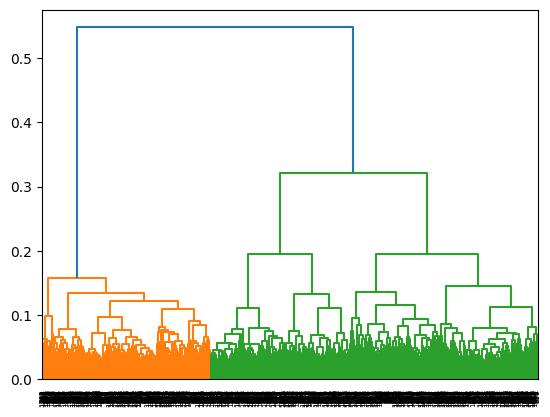

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
normalized_data = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy()

linkage_data = linkage(normalized_data, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

In [35]:
clusters = fcluster(linkage_data, t=0.3 , criterion='distance')

In [44]:
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(normalized_data)

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(normalized_data)

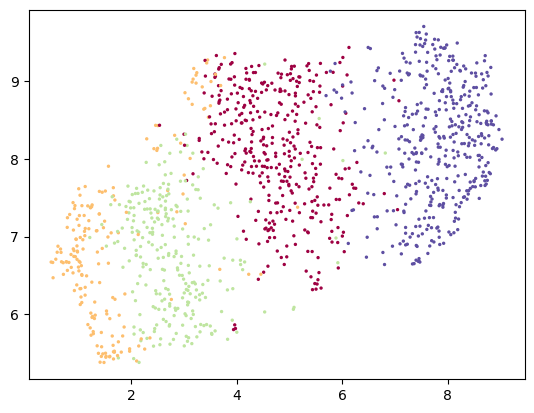

In [56]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=2, cmap ='Spectral')

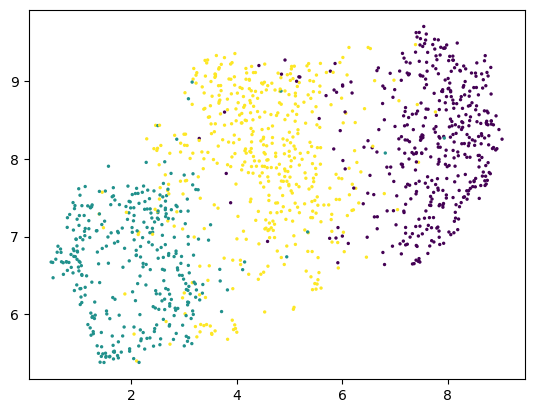

In [57]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clusters, s=2)

In [58]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(normalized_data)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fillpattern': {'shape': ''},
              'hovertemplate': '# Components=%{x}<br>Explained Variance=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'stackgroup': '1',
              'type': 'scatter',
              'x': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
                           15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
                           29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
                           43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
                           57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
                           71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
                           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
                          113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
                          127], dtype=int64),
              'xaxis': 'x',
              'y': array([0.16431526, 0.22268661, 0.26733163, 0.3062504 , 0.33729686, 0.36547652,
                          0.38740197, 0.40636245, 0.42269184, 0.43722626, 0.45086957, 0.46429161,
                          0.47707301, 0.48946263, 0.50159836, 0.51287154, 0.52368253, 0.53414171,
                          0.54439541, 0.55452084, 0.56429787, 0.57361048, 0.58281873, 0.59171856,
                          0.60048736, 0.60909364, 0.61764012, 0.62598622, 0.63403914, 0.64207155,
                          0.64987395, 0.65759156, 0.66509934, 0.67239094, 0.67964621, 0.68669999,
                          0.69363758, 0.70034525, 0.70700535, 0.71348707, 0.71993262, 0.72619737,
                          0.73243223, 0.7386253 , 0.74465202, 0.75065711, 0.75651366, 0.76224577,
                          0.76789011, 0.77347096, 0.77887593, 0.78425205, 0.78945634, 0.79456998,
                          0.79965927, 0.80468713, 0.8096729 , 0.81452613, 0.81929967, 0.82402433,
                          0.82871399, 0.83330742, 0.83780238, 0.84224401, 0.84666758, 0.85098697,
                          0.85522374, 0.85936612, 0.86347748, 0.86750001, 0.87148204, 0.87542158,
                          0.87931229, 0.88310279, 0.88682229, 0.89053591, 0.89415568, 0.89772922,
                          0.90122402, 0.90470386, 0.90812833, 0.91146886, 0.91473454, 0.91795909,
                          0.92113944, 0.92428743, 0.92735257, 0.93040975, 0.93334783, 0.93622116,
                          0.93907665, 0.94186338, 0.94461336, 0.94729911, 0.94990411, 0.95244029,
                          0.95495732, 0.95737901, 0.95972253, 0.96206044, 0.96426573, 0.96644613,
                          0.96858334, 0.97063383, 0.97265286, 0.97461894, 0.97658145, 0.97847935,
                          0.98036716, 0.98223984, 0.9840071 , 0.98570591, 0.98737283, 0.98901257,
                          0.99058002, 0.99203296, 0.99346144, 0.99477663, 0.99605776, 0.99728379,
                          0.99823744, 0.99908547, 0.99956115, 0.9999829 , 1.        , 1.        ,
                          1.        ]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': '# Components'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Explained Variance'}}}
})

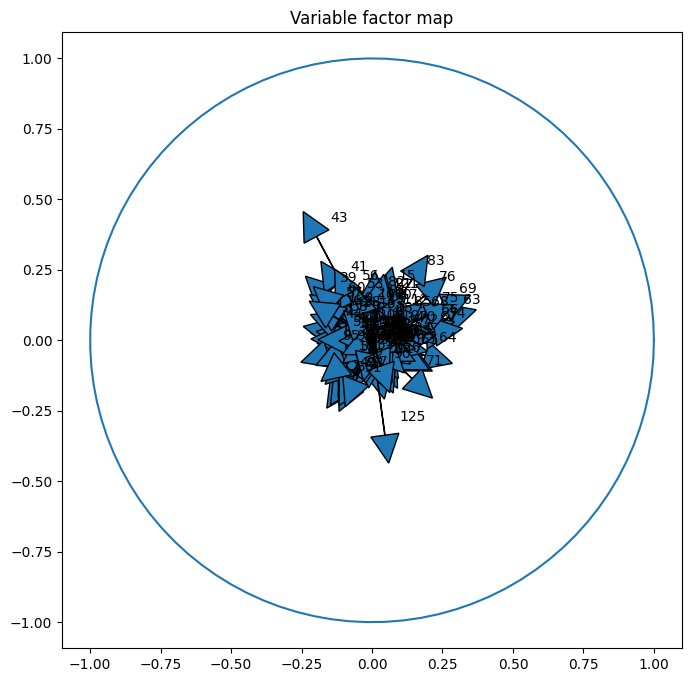

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 

 
n_components = 80 #scaled.shape[1]
 
# Do the PCA.
pca = PCA(n_components=n_components)
pca.fit_transform(np.copy(normalized_data))


# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             i)


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

SNV info 

- 43 : TET2
- 125 : U2AF1

In [63]:
amplicons.iloc[43]

CHROM                            b'4'
end_pos                     106158015
id           b'AML_v2_TET2_106157777'
r1_counts                       90216
r2_counts                       90230
start_pos                   106157757
Name: 43, dtype: object

In [64]:
amplicons.iloc[125]

CHROM                           b'21'
end_pos                      44514808
id           b'AML_v2_U2AF1_44514570'
r1_counts                       65367
r2_counts                       65269
start_pos                    44514550
Name: 125, dtype: object

# Ridgeline

In [36]:
normalized_read = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).T
#normalized_read['amplicon'] = normalized_read.index

In [34]:
normalized_read

,b'AACAACCTACAGAAGTGA-1',b'AACAACCTATCTATGACA-1',b'AACAACTGGCAACGCACA-1',b'AACACACTCTTACAGTGT-1',b'AACAGCAGTCGTCTGCTG-1',b'AACAGCAGTGATGCTCCT-1',b'AACCGCTGAAACAACCTA-1',b'AACCGCTGAACCACGCTA-1',b'AACGCATTGCGTTAATGG-1',b'AACGCCTACACCATACTT-1',...,b'TTGCAGTCATGCTATGAA-1',b'TTGCCAGATATGGACGTT-1',b'TTGCCAGATTCCTTCGTA-1',b'TTGCCGTAGAGATGAGAT-1',b'TTGCCGTAGGAGGTGAGC-1',b'TTGGACTTCCGCTTATGA-1',b'TTGGAGAACTGAACTTGC-1',b'TTGGTAACTTCTGCGCTG-1',b'TTGTCAACCGCAGCAGTG-1',b'TTGTTAGAGAATCTCCTA-1'
b'AML_v2_NRAS_115256512',0.008457,0.003744,0.013091,0.013604,0.006147,0.010802,0.006612,0.008097,0.009553,0.008205,...,0.012910,0.006667,0.009376,0.010303,0.012465,0.00468,0.012173,0.009516,0.014274,0.011126
b'AML_v2_NRAS_115258635',0.006857,0.006467,0.007736,0.007148,0.006345,0.005492,0.012909,0.007422,0.009834,0.008044,...,0.004965,0.008485,0.008561,0.007879,0.005298,0.00208,0.000112,0.009723,0.008688,0.012153
b'AML_v2_DNMT3A_25457166',0.005257,0.008509,0.002975,0.005073,0.008328,0.006957,0.005982,0.006973,0.004215,0.007722,...,0.003310,0.006061,0.007134,0.009394,0.004363,0.00988,0.005584,0.004137,0.004137,0.005478
b'AML_v2_DNMT3A_25458540',0.009143,0.007488,0.006843,0.010145,0.014674,0.010619,0.009761,0.014395,0.011239,0.009170,...,0.013241,0.010909,0.011822,0.013939,0.012465,0.00988,0.011392,0.011998,0.010757,0.009586
b'AML_v2_DNMT3A_25459813',0.004571,0.001702,0.007438,0.001614,0.001785,0.000915,0.000315,0.003599,0.002810,0.003057,...,0.001324,0.003030,0.005300,0.002727,0.000312,0.00468,0.002122,0.006413,0.002276,0.002910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'AML_v2_RUNX1_36206703',0.007771,0.011913,0.005951,0.010837,0.007932,0.007689,0.005982,0.006523,0.009553,0.004665,...,0.010593,0.006970,0.008357,0.007273,0.008414,0.00832,0.005696,0.010343,0.009930,0.010442
b'AML_v2_RUNX1_36231714',0.007543,0.011232,0.002678,0.004381,0.007139,0.003662,0.005982,0.003599,0.001405,0.004665,...,0.002979,0.002121,0.003057,0.004242,0.003739,0.00208,0.003350,0.005792,0.004758,0.002739
b'AML_v2_RUNX1_36252844',0.010286,0.011572,0.010711,0.010606,0.012294,0.007689,0.009446,0.011021,0.012644,0.009170,...,0.007613,0.011212,0.011618,0.008788,0.008102,0.00676,0.014407,0.011585,0.009102,0.014721
b'AML_v2_U2AF1_44514570',0.012114,0.015997,0.010414,0.014526,0.012096,0.009703,0.009446,0.019793,0.014049,0.012227,...,0.000000,0.015758,0.007949,0.009394,0.013088,0.01092,0.014854,0.014067,0.010343,0.016775


In [37]:
data_facetgrid = normalized_read.stack().reset_index(level=1,drop=True).to_frame()
data_facetgrid['amplicon'] = data_facetgrid.index
data_facetgrid

,0,amplicon
b'AML_v2_NRAS_115256512',0.008457,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.003744,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.013091,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.013604,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.006147,b'AML_v2_NRAS_115256512'
...,...,...
b'AML_v2_U2AF1_44524438',0.008320,b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438',0.010275,b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438',0.009309,b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438',0.009930,b'AML_v2_U2AF1_44524438'


In [49]:
data_facetgrid.iloc[:2480]

,0,amplicon
b'AML_v2_NRAS_115256512',0.008457,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.003744,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.013091,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.013604,b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512',0.006147,b'AML_v2_NRAS_115256512'
...,...,...
b'AML_v2_NRAS_115258635',0.002080,b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635',0.000112,b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635',0.009723,b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635',0.008688,b'AML_v2_NRAS_115258635'


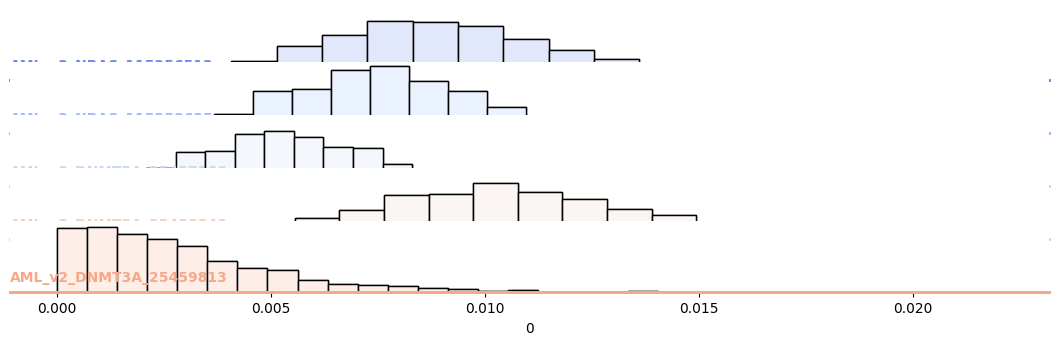

In [42]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm')

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(data_facetgrid.iloc[:6200], row='amplicon' , hue='amplicon', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.histplot, 0,
      fill=True, bins=20)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.histplot, 0, 
      bins=20, 
      color="w")
"""g.map(sns.kdeplot, 0,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 0, 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)"""

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 0)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)